In [1]:
# Desafio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


import os

In [2]:
archivo=os.listdir()
archivo

['.DS_Store',
 '.ipynb_checkpoints',
 '01 - Boosting.ipynb',
 '03_d_Desafío_-_Modelos_de_ensamble__Parte_II_.pdf',
 'df_cleaned.csv',
 'df_cleaned_with_dummies.csv',
 'feature_names.csv',
 'Gui╠üa - Modelos de ensamble (Parte II).ipynb',
 'local_utils.py',
 'processed.cleveland.data',
 'processed.hungarian.data',
 'processed.switzerland.data',
 'Untitled.ipynb']

In [3]:
# Lista de archivos de datos
data_files = ["processed.cleveland.data", "processed.hungarian.data", "processed.switzerland.data"]

# Cargar los nombres de las columnas
column_names = pd.read_csv("feature_names.csv", header=None)
column_names = column_names[0].tolist()


# Leer y combinar los archivos
df1 = pd.read_csv(data_files[0], header=None, names=column_names)
df2 = pd.read_csv(data_files[1], header=None, names=column_names)
df3 = pd.read_csv(data_files[2], header=None, names=column_names)

# Concatenar los DataFrames
df_combined = pd.concat([df1, df2, df3], ignore_index=True)



In [4]:
df_combined

,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,70.0,1.0,4.0,115,0,0,1,92,1,0,2,?,7,1
716,70.0,1.0,4.0,140,0,1,0,157,1,2,2,?,7,3
717,72.0,1.0,3.0,160,0,?,2,114,0,1.6,2,2,?,0
718,73.0,0.0,3.0,160,0,0,1,121,0,0,1,?,3,1


In [5]:
# Filtrar filas donde alguna columna contenga el valor "?"
df_with_question_marks = df_combined[df_combined.apply(lambda row: '?' in row.values, axis=1)]

pd.set_option("display.max_rows", None)  # Para ver todas las filas
df_with_question_marks.head()


,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0


In [6]:
# Cargar el DataFrame (asegúrate de que 'df_combined' esté definido antes de ejecutar esto)
# Reemplazar "?" por NaN
df_combined.replace("?", np.nan, inplace=True)

# Convertir la variable objetivo 'num' en binaria (0 = sin enfermedad, 1 = con enfermedad)
df_combined['num'] = df_combined['num'].astype(int).apply(lambda x: 0 if x == 0 else 1)

# Calcular el porcentaje de valores ausentes en cada columna
missing_percent = df_combined.isnull().mean() * 100

# Mostrar cantidad de valores ausentes antes del procesamiento
print("Valores ausentes antes del procesamiento:\n", df_combined.isnull().sum())

# Eliminar atributos con más del 25% de valores ausentes
df_cleaned = df_combined.loc[:, missing_percent <= 25]

# Rellenar valores ausentes según la clase en la columna 'num'
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().sum() > 0:  # Si hay valores nulos en la columna
        if df_cleaned[col].dtype in ['float64', 'int64']:  # Si la columna es numérica
            # Calcular el promedio según la clase (num=0 y num=1)
            mean_0 = df_cleaned[df_cleaned['num'] == 0][col].mean()
            mean_1 = df_cleaned[df_cleaned['num'] == 1][col].mean()

            # Rellenar los valores nulos con el promedio correspondiente
            df_cleaned.loc[(df_cleaned[col].isnull()) & (df_cleaned['num'] == 0), col] = mean_0
            df_cleaned.loc[(df_cleaned[col].isnull()) & (df_cleaned['num'] == 1), col] = mean_1
        else:  # Si la columna es categórica, redondear al entero más cercano
            mean_0 = round(df_cleaned[df_cleaned['num'] == 0][col].astype(float).mean())
            mean_1 = round(df_cleaned[df_cleaned['num'] == 1][col].astype(float).mean())

            df_cleaned.loc[(df_cleaned[col].isnull()) & (df_cleaned['num'] == 0), col] = mean_0
            df_cleaned.loc[(df_cleaned[col].isnull()) & (df_cleaned['num'] == 1), col] = mean_1

# Mostrar cantidad de valores ausentes después del procesamiento
print("\nValores ausentes después del procesamiento:\n", df_cleaned.isnull().sum())

# Guardar el DataFrame limpio en un archivo CSV
df_cleaned.to_csv("df_cleaned.csv", index=False)

# Mostrar las primeras filas del DataFrame limpio
print("\nDataFrame después de la limpieza:")
df_cleaned.head()


Valores ausentes antes del procesamiento:
 age            0
sex            0
cp             0
threstbps      3
chol          23
fbs           83
restecg        2
thalach        2
exang          2
oldpeak        6
slope        207
ca           413
thal         320
num            0
dtype: int64

Valores ausentes después del procesamiento:
 age          0
sex          0
cp           0
threstbps    0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
num          0
dtype: int64

DataFrame después de la limpieza:


,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,0


In [7]:
# Lista de posibles variables categóricas con tres o más categorías
categorical_columns = ['cp', 'restecg', 'slope', 'thal']

# Filtrar solo las columnas que realmente existen en el DataFrame
existing_categorical_columns = [col for col in categorical_columns if col in df_cleaned.columns]

# Convertir las variables categóricas en variables dummies solo si existen
if existing_categorical_columns:
    df_cleaned = pd.get_dummies(df_cleaned, columns=existing_categorical_columns, drop_first=True)

# Guardar el DataFrame con las variables dummies
df_cleaned.to_csv("df_cleaned_with_dummies.csv", index=False)

# Mostrar las primeras filas del DataFrame actualizado
df_cleaned.head()


,age,sex,threstbps,chol,fbs,thalach,exang,oldpeak,num,cp_2.0,cp_3.0,cp_4.0,restecg_1.0,restecg_2.0,restecg_0,restecg_1,restecg_2
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0,False,False,False,False,True,False,False,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,False,False,True,False,True,False,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1,False,False,True,False,True,False,False,False
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0,False,True,False,False,False,False,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0,True,False,False,False,True,False,False,False


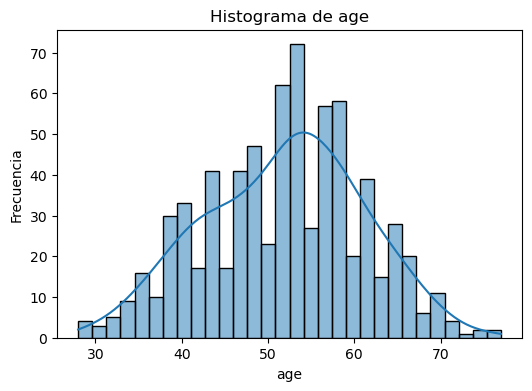

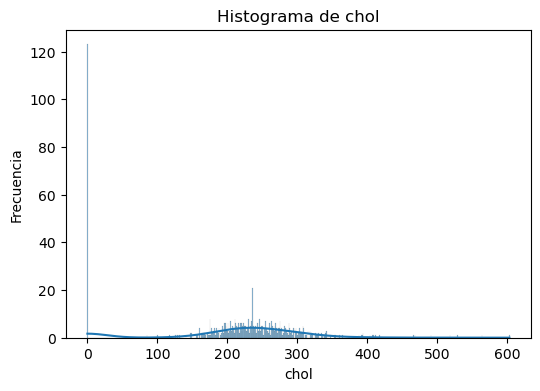

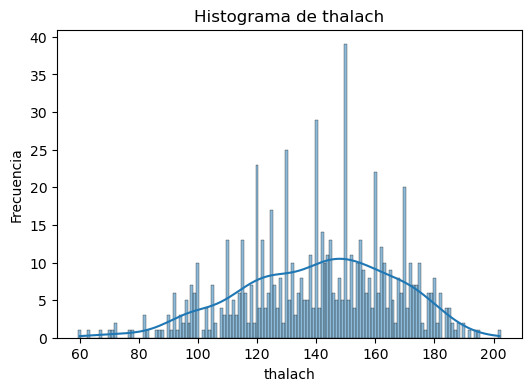

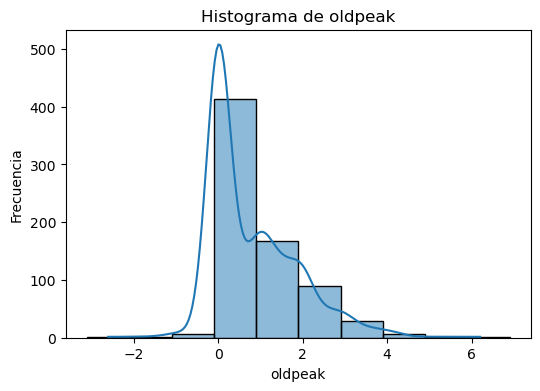

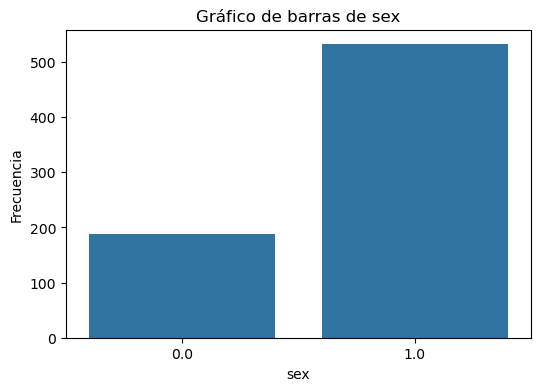

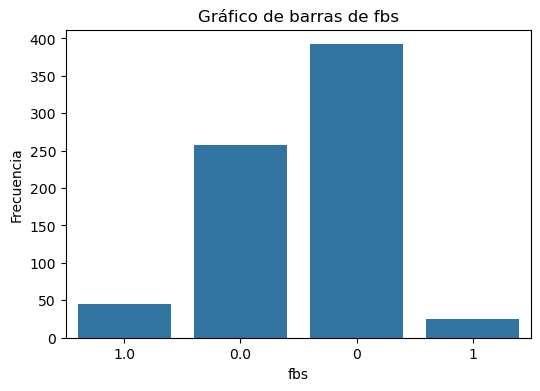

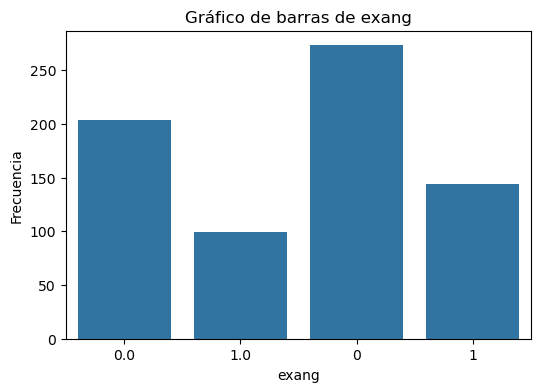

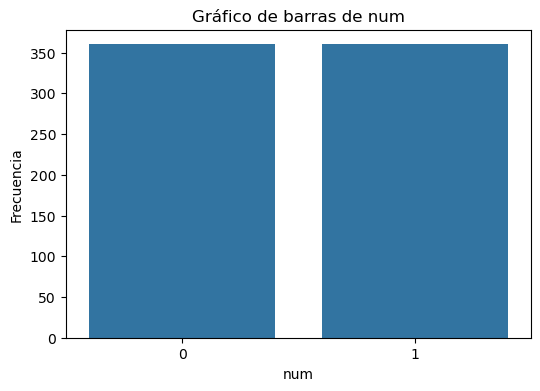

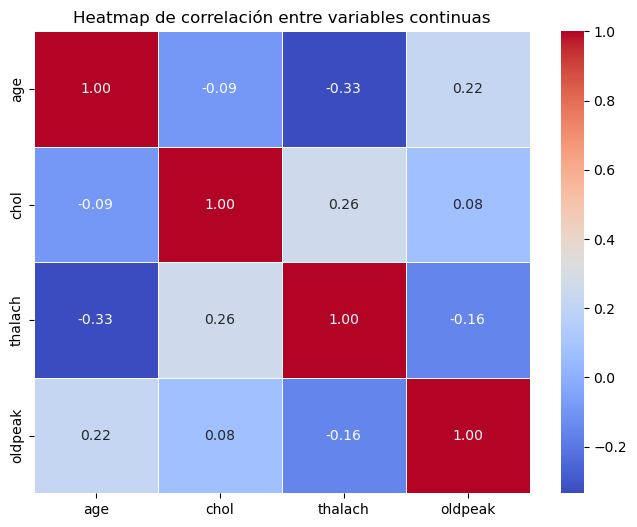

In [8]:

# Verificar qué columnas existen en el DataFrame
available_columns = df_cleaned.columns

# Filtrar solo las variables continuas que realmente existen en el DataFrame
continuous_vars = [col for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'] if col in available_columns]

# Filtrar solo las variables categóricas que realmente existen en el DataFrame
categorical_vars = [col for col in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num'] if col in available_columns]

# Crear histogramas para variables continuas
for col in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_cleaned[col], bins=30, kde=True)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# Crear gráficos de barra para variables categóricas
for col in categorical_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df_cleaned)
    plt.title(f'Gráfico de barras de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# Construir la matriz de correlación para variables continuas si hay al menos dos variables
if len(continuous_vars) > 1:
    correlation_matrix = df_cleaned[continuous_vars].corr()

    # Visualizar el heatmap de correlaciones
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Heatmap de correlación entre variables continuas')
    plt.show()
else:
    print("No hay suficientes variables continuas para calcular la correlación.")


In [9]:
# Separar las características y la variable objetivo
X = df_cleaned.drop(columns=['num'])
y = df_cleaned['num']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

 # AdaBoost

In [11]:
# Separar las características y la variable objetivo
X = df_cleaned.drop(columns=['num'])
y = df_cleaned['num']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar el modelo AdaBoost con hiperparámetros por defecto
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = adaboost.predict(X_test)

# Evaluar el desempeño del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Mostrar resultados
print(f"Exactitud del modelo AdaBoost: {accuracy:.4f}\n")
print("Matriz de Confusión:")
print(conf_matrix)
print("\nReporte de Clasificación:")
print(classification_rep)

Exactitud del modelo AdaBoost: 0.8472

Matriz de Confusión:
[[61 11]
 [11 61]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        72
           1       0.85      0.85      0.85        72

    accuracy                           0.85       144
   macro avg       0.85      0.85      0.85       144
weighted avg       0.85      0.85      0.85       144



C:\Users\franc\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


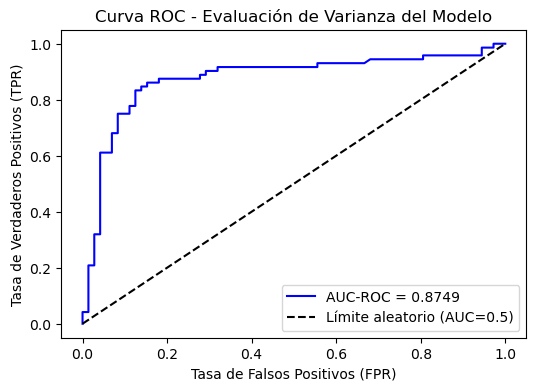

AUC-ROC del modelo AdaBoost: 0.8749


In [12]:
# Calcular la probabilidad de predicción para la clase positiva
y_probs = adaboost.predict_proba(X_test)[:, 1]

# Calcular el AUC-ROC
auc_roc = roc_auc_score(y_test, y_probs)

# Graficar la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Límite aleatorio (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Evaluación de Varianza del Modelo')
plt.legend()
plt.show()

# Mostrar el valor de AUC-ROC
print(f"AUC-ROC del modelo AdaBoost: {auc_roc:.4f}")

# Gradient Boosting

Exactitud del modelo Gradient Boosting: 0.8472

Matriz de Confusión:
[[62 10]
 [12 60]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        72
           1       0.86      0.83      0.85        72

    accuracy                           0.85       144
   macro avg       0.85      0.85      0.85       144
weighted avg       0.85      0.85      0.85       144


AUC-ROC del modelo Gradient Boosting: 0.8945


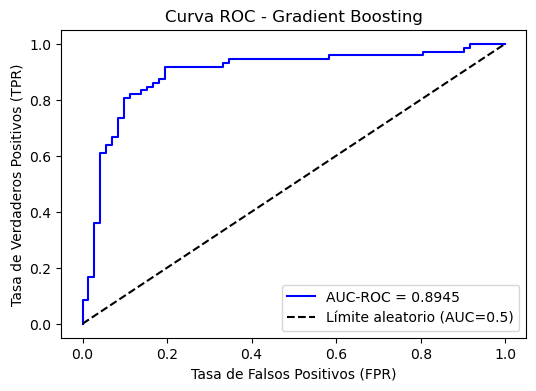

In [14]:
# Entrenar el modelo Gradient Boosting con hiperparámetros por defecto
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Evaluar el desempeño del modelo
accuracy_gb = accuracy_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
classification_rep_gb = classification_report(y_test, y_pred_gb)

# Calcular AUC-ROC para Gradient Boosting
y_probs_gb = gb_model.predict_proba(X_test)[:, 1]
auc_roc_gb = roc_auc_score(y_test, y_probs_gb)

# Mostrar resultados
print(f"Exactitud del modelo Gradient Boosting: {accuracy_gb:.4f}\n")
print("Matriz de Confusión:")
print(conf_matrix_gb)
print("\nReporte de Clasificación:")
print(classification_rep_gb)
print(f"\nAUC-ROC del modelo Gradient Boosting: {auc_roc_gb:.4f}")

# Graficar la curva ROC
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_probs_gb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_gb, tpr_gb, label=f'AUC-ROC = {auc_roc_gb:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Límite aleatorio (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Gradient Boosting')
plt.legend()
plt.show()


# XGBoost
### Se comete un error al correr este modelo, que es explicado y corregido mas adelante. 

C:\Users\franc\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Exactitud del modelo XGBoost: 0.7917

Matriz de Confusión:
[[57 15]
 [15 57]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        72
           1       0.79      0.79      0.79        72

    accuracy                           0.79       144
   macro avg       0.79      0.79      0.79       144
weighted avg       0.79      0.79      0.79       144


AUC-ROC del modelo XGBoost: 0.8661


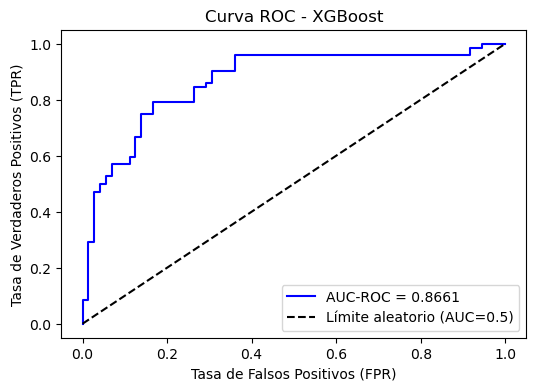

In [33]:
# Separar características y variable objetivo
X = df_cleaned.drop(columns=['num'])
y = df_cleaned['num']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar el modelo XGBoost con hiperparámetros por defecto
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el desempeño del modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

# Calcular AUC-ROC para XGBoost
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
auc_roc_xgb = roc_auc_score(y_test, y_probs_xgb)

# Mostrar resultados
print(f"Exactitud del modelo XGBoost: {accuracy_xgb:.4f}\n")
print("Matriz de Confusión:")
print(conf_matrix_xgb)
print("\nReporte de Clasificación:")
print(classification_rep_xgb)
print(f"\nAUC-ROC del modelo XGBoost: {auc_roc_xgb:.4f}")

# Graficar la curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC-ROC = {auc_roc_xgb:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Límite aleatorio (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.show()

# CUIDADO !!!

📌 Diferencias en el Manejo de Datos entre AdaBoost, Gradient Boosting y XGBoost
Modelo	Manejador Interno	Requerimiento de Tipo de Datos
AdaBoost	Usa Árboles de Decisión de Sklearn	Convierte automáticamente los datos a numéricos.
Gradient Boosting	Usa Árboles de Sklearn	Permite trabajar con datos que parecen categóricos (object) sin fallar.
XGBoost	Usa DMatrix (estructura propia de XGBoost)	Requiere datos explícitamente numéricos (int, float).

In [20]:
# Convertir valores booleanos a enteros (0 y 1)
df_cleaned = df_cleaned.astype({col: 'int' for col in df_cleaned.select_dtypes(include=['bool']).columns})

# Convertir todas las columnas numéricas que aún son 'object' a float
df_cleaned = df_cleaned.apply(pd.to_numeric, errors='coerce')

# Verificar que todas las columnas sean numéricas
print(df_cleaned.dtypes)

age            float64
sex            float64
threstbps      float64
chol           float64
fbs            float64
thalach        float64
exang          float64
oldpeak        float64
num              int64
cp_2.0           int32
cp_3.0           int32
cp_4.0           int32
restecg_1.0      int32
restecg_2.0      int32
restecg_0        int32
restecg_1        int32
restecg_2        int32
dtype: object


# Corremos nuevamente XGBoost

C:\Users\franc\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Exactitud del modelo XGBoost: 0.7917

Matriz de Confusión:
[[57 15]
 [15 57]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        72
           1       0.79      0.79      0.79        72

    accuracy                           0.79       144
   macro avg       0.79      0.79      0.79       144
weighted avg       0.79      0.79      0.79       144


AUC-ROC del modelo XGBoost: 0.8661


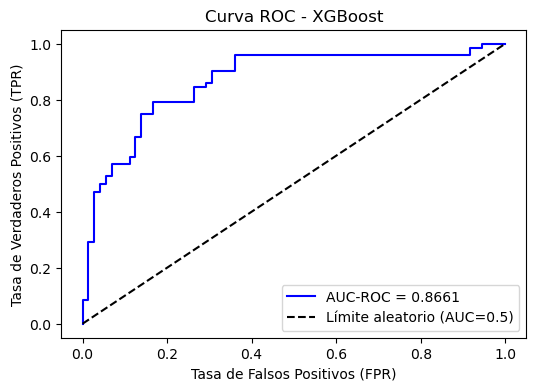

In [23]:
# Separar características y variable objetivo
X = df_cleaned.drop(columns=['num'])
y = df_cleaned['num']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar el modelo XGBoost con hiperparámetros por defecto
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar el desempeño del modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

# Calcular AUC-ROC para XGBoost
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
auc_roc_xgb = roc_auc_score(y_test, y_probs_xgb)

# Mostrar resultados
print(f"Exactitud del modelo XGBoost: {accuracy_xgb:.4f}\n")
print("Matriz de Confusión:")
print(conf_matrix_xgb)
print("\nReporte de Clasificación:")
print(classification_rep_xgb)
print(f"\nAUC-ROC del modelo XGBoost: {auc_roc_xgb:.4f}")

# Graficar la curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC-ROC = {auc_roc_xgb:.4f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Límite aleatorio (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.show()

# GradientBoosting con Hiperparametros

In [26]:
# Definir la grilla de hiperparámetros para Gradient Boosting
param_grid = {
    'n_estimators': np.linspace(20, 200, 15, dtype=int),  # 15 valores entre 20 y 200
    'learning_rate': np.linspace(0.004, 1.0, 40),  # 40 valores entre 0.004 y 1.0
    'subsample': np.linspace(0.1, 1.0, 18)  # 18 valores entre 0.1 y 1.0
}

# Inicializar el modelo
gb_model = GradientBoostingClassifier(random_state=42)

# Realizar la búsqueda de hiperparámetros usando GridSearchCV
grid_search = GridSearchCV(
    gb_model, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1
)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Mostrar los resultados
print(f"Mejores hiperparámetros encontrados: {best_params}")
print(f"Mejor F1-score en validación cruzada: {best_score:.4f}")

Fitting 5 folds for each of 10800 candidates, totalling 54000 fits
Mejores hiperparámetros encontrados: {'learning_rate': 0.08061538461538462, 'n_estimators': 97, 'subsample': 0.41764705882352937}
Mejor F1-score en validación cruzada: 0.8401


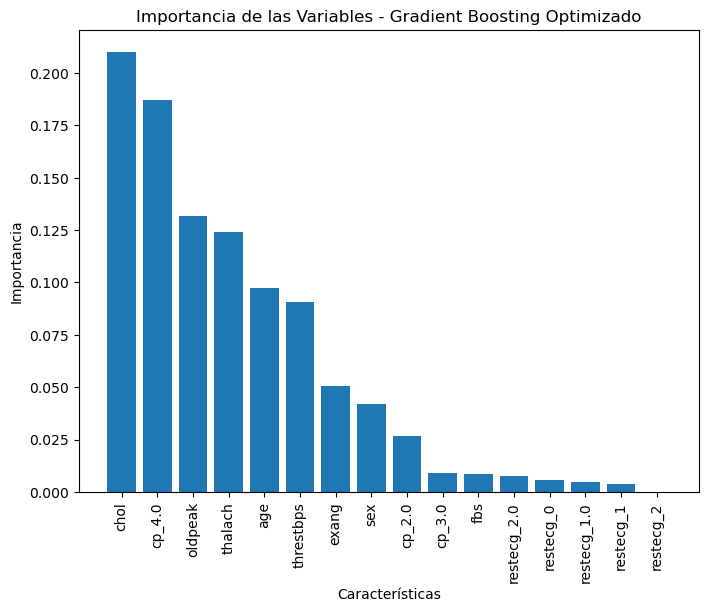

{'chol': 0.21000004343073278,
 'cp_4.0': 0.1872611967336569,
 'oldpeak': 0.13162939599818016,
 'thalach': 0.12423963704074249,
 'age': 0.09711339506233514,
 'threstbps': 0.09081024906242341,
 'exang': 0.05053146760876359,
 'sex': 0.0419645530786902,
 'cp_2.0': 0.026659992463248208,
 'cp_3.0': 0.009273711892471316,
 'fbs': 0.00846963470993955,
 'restecg_2.0': 0.007564475950868324,
 'restecg_0': 0.005719944273142651,
 'restecg_1.0': 0.004847205116963926,
 'restecg_1': 0.003915097577841268,
 'restecg_2': 0.0}

In [30]:
# Verificar si GridSearchCV encontró un modelo óptimo
if grid_search.best_estimator_ is not None:
    best_model = grid_search.best_estimator_
else:
    raise ValueError("No se encontró un mejor modelo en GridSearchCV.")

# Obtener la importancia de las características del mejor modelo
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

# Ordenar las características por importancia
sorted_idx = np.argsort(feature_importances)[::-1]

# Graficar la importancia de las características
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de las Variables - Gradient Boosting Optimizado")
plt.show()

# Mostrar las variables con sus valores de importancia
feature_importance_dict = {feature_names[i]: feature_importances[i] for i in sorted_idx}
feature_importance_dict

# Probemos el modelo haciendo una estimacion 

In [37]:
# Obtener el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
y_pred_best = best_model.predict(X_test)

# Calcular la probabilidad de predicción (para análisis de confianza)
y_probs_best = best_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo con métricas clave
accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
classification_rep_best = classification_report(y_test, y_pred_best)
auc_roc_best = roc_auc_score(y_test, y_probs_best)

# Mostrar resultados
print(f"Exactitud del Mejor Modelo: {accuracy_best:.4f}")
print("\nMatriz de Confusión:")
print(conf_matrix_best)
print("\nReporte de Clasificación:")
print(classification_rep_best)
print(f"\nAUC-ROC del Mejor Modelo: {auc_roc_best:.4f}")

Exactitud del Mejor Modelo: 0.8403

Matriz de Confusión:
[[59 13]
 [10 62]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        72
           1       0.83      0.86      0.84        72

    accuracy                           0.84       144
   macro avg       0.84      0.84      0.84       144
weighted avg       0.84      0.84      0.84       144


AUC-ROC del Mejor Modelo: 0.9062


# Datos de prueba

In [42]:
# Crear una fila de prueba con valores representativos y respetando la estructura de dummies
test_row = pd.DataFrame({
    'age': [55],
    'sex': [1],
    'trestbps': [130],
    'chol': [250],
    'fbs': [0],
    'thalach': [160],
    'exang': [0],
    'oldpeak': [1.0],
    'ca': [1],

    # Columnas dummies generadas por get_dummies()
    'cp_2.0': [1], 'cp_3.0': [0], 'cp_4.0': [0],  # Solo activamos cp_2.0
    'restecg_0': [0], 'restecg_1': [1], 'restecg_2': [0],  # Activamos restecg_1
    'thal_3.0': [1], 'thal_6.0': [0], 'thal_7.0': [0],  # Activamos thal_3.0
    'slope_1.0': [0], 'slope_2.0': [1], 'slope_3.0': [0]  # Activamos slope_2.0
})

# Asegurar que la fila de prueba tenga las mismas columnas que el conjunto de entrenamiento
test_row = test_row.reindex(columns=X_test.columns, fill_value=0)

# Hacer la predicción con el mejor modelo encontrado
y_pred_test = best_model.predict(test_row)
y_prob_test = best_model.predict_proba(test_row)[:, 1]

# Mostrar los resultados
print(f"Predicción del modelo: {y_pred_test[0]} (0 = Sin enfermedad, 1 = Con enfermedad)")
print(f"Probabilidad de tener la enfermedad: {y_prob_test[0]:.4f}")

Predicción del modelo: 0 (0 = Sin enfermedad, 1 = Con enfermedad)
Probabilidad de tener la enfermedad: 0.1260
